In [8]:
import osmnx as ox

# Define the place name or coordinates
place_name = "Kathmandu, Nepal"  # Example place

# Download the street network
G = ox.graph_from_place(place_name, network_type='all')  # 'all' includes all types of roads


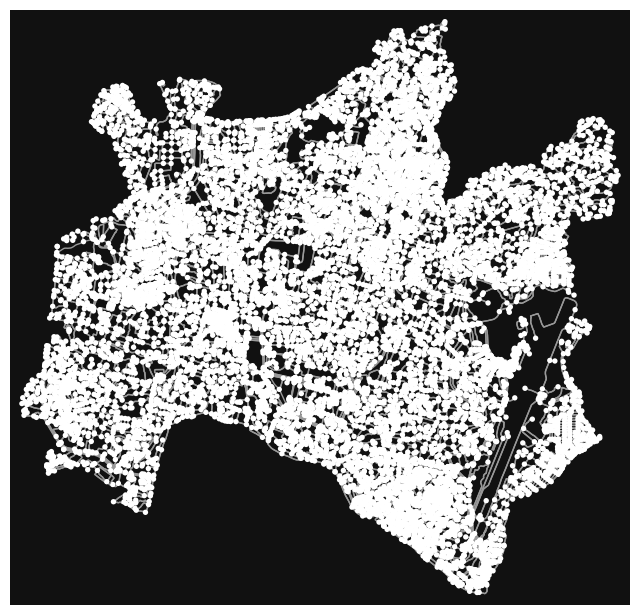

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
ox.plot_graph(G)

In [17]:
# Function to infer a node's "name" based on its connected streets
def get_node_name(node_id, G):
    # Get all edges connected to this node
    edges = list(G.edges(node_id, data=True))
    
    # Collect street names from edges
    street_names = [data['name'] for  v, key, data in edges if 'name' in data]
    
    # If no street names are found, return a default
    if not street_names:
        return f"Node {node_id} (Unnamed streets)"
    
    # Return a concatenated string of street names (or just the first street name)
    return ', '.join(street_names[:2])  # Limiting to first 2 street names for simplicity

# Example: Get the "name" of the first node
node_id = list(G.nodes)[0]
node_name = get_node_name(node_id, G)
print(f"Node {node_id} is near: {node_name}")

Node 31019057 is near: चाबहिल-बौद्ध-जोरपाटी सडक, चाबहिल-बौद्ध-जोरपाटी सडक
